In [1]:
import warnings
from joblib import parallel_backend

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


FEATURES_TO_USE = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

param_grid = {
    'data_pipe__preprocessor__num__imputer__strategy': ['mean', 'median', 'most_frequent', 'constant'],
    'data_pipe__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler()],
    'data_pipe__preprocessor__cat__imputer__strategy': ['mean', 'median', 'most_frequent', 'constant'],
    'data_pipe__feature_selector__k': [3, 5, 7],
    'classifier': [LogisticRegression()],
    'classifier__C': [10, 0.1, 1],
    'classifier__solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
}


df_train = pd.read_csv('../data/titanic.csv', index_col='PassengerId')
df_train = df_train[FEATURES_TO_USE]
x_train = df_train.drop(columns='Survived')
y_train = df_train['Survived']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
feature_selector = SelectKBest(k='all')

data_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
])

pipeline = Pipeline(steps=[
    ('data_pipe', data_pipe),
    ('classifier', LogisticRegression(max_iter=1000))
])


skf = StratifiedKFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, verbose=1)

with warnings.catch_warnings(), parallel_backend("threading", n_jobs=1):
    warnings.filterwarnings("ignore")
    grid_search.fit(x_train, y_train)

print("Best Parameters found:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Parameters found: {'classifier': LogisticRegression(), 'classifier__C': 10, 'classifier__solver': 'liblinear', 'data_pipe__feature_selector__k': 3, 'data_pipe__preprocessor__cat__imputer__strategy': 'most_frequent', 'data_pipe__preprocessor__num__imputer__strategy': 'mean', 'data_pipe__preprocessor__num__scaler': MinMaxScaler()}
Best Cross-Validation Score: 0.7867867679367272


In [2]:
best_model

,steps,"[('data_pipe', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('preprocessor', ...), ('feature_selector', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3


In [3]:
df_test = pd.read_csv('../data/titanic_test.csv', index_col='PassengerId')
df_test = df_test[FEATURES_TO_USE]
x_test = df_test.drop(columns='Survived')
y_test = df_test['Survived']

y_pred = best_model.predict(x_test)



accuracy_score(y_test, y_pred)

1.0

---

In [4]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       152

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418



In [5]:
best_model.named_steps['data_pipe'].named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']

,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [6]:
feature_selector = best_model.named_steps['data_pipe'].named_steps['feature_selector']
categorical_transformer = best_model.named_steps['data_pipe'].named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']

feature_names = []
feature_names.extend(numeric_features)
encoded_cat_features = categorical_transformer.get_feature_names_out(categorical_features)
feature_names.extend(encoded_cat_features)

feature_names

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [7]:
import numpy as np
selected_mask = feature_selector.get_support()
selected_features = np.array(feature_names)[selected_mask]

# Print the result
print("Selected features:")
print(selected_features.tolist())

Selected features:
['Pclass_3', 'Sex_female', 'Sex_male']


In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
FEATURES_TO_USE = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

## Preprocessing functions

Functions to fill in the missing values

In [3]:
def fill_missing_embarked(df: pd.DataFrame) -> pd.DataFrame:
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    return df

def fill_missing_age(df: pd.DataFrame) -> pd.DataFrame:
    df['Age'] = df['Age'].fillna(df['Age'].median())
    return df

def fill_missing_fare(df: pd.DataFrame) -> pd.DataFrame:
    for p_class in range(1, 4):
        Pclass_median = df[(df['Pclass'] == p_class) & (df['Fare'].notna())]['Fare'].median()
        df.loc[(df['Pclass'] == p_class) & (df['Fare'].isna() | (df['Fare'] == 0.0)), 'Fare'] = Pclass_median
    return df

Function to convert strings to categorical values

In [4]:
def sex_to_categorical(df: pd.DataFrame) -> pd.DataFrame:
    df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
    return df

def embarked_to_categorical(df: pd.DataFrame) -> pd.DataFrame:
    df['Embarked'] = df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
    return df

## Import and preprocess data

In [5]:
df_train = pd.read_csv('data/titanic.csv', index_col='PassengerId')
print(df_train.shape)
df_train = fill_missing_embarked(df_train)
df_train = fill_missing_age(df_train)
df_train = fill_missing_fare(df_train)
df_train = df_train[FEATURES_TO_USE]
df_train = sex_to_categorical(df_train)
df_train = embarked_to_categorical(df_train)
df_train.head()

(891, 11)


/tmp/ipykernel_100196/3889848298.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipykernel_100196/3889848298.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Embarked'] = df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0
2,1,1,1,38.0,1,0,71.2833,1
3,1,3,1,26.0,0,0,7.9250,0
4,1,1,1,35.0,1,0,53.1000,0
5,0,3,0,35.0,0,0,8.0500,0


In [6]:
df_test = pd.read_csv('data/titanic_test.csv', index_col='PassengerId')
print(df_test.shape)
df_test = fill_missing_embarked(df_test)
df_test = fill_missing_age(df_test)
df_test = fill_missing_fare(df_test)
df_test = df_test[FEATURES_TO_USE]
df_test = sex_to_categorical(df_test)
df_test = embarked_to_categorical(df_test)
df_test.head()

(418, 11)


/tmp/ipykernel_100196/3889848298.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipykernel_100196/3889848298.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Embarked'] = df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
892,0,3,0,34.5,0,0,7.8292,2
893,1,3,1,47.0,1,0,7.0000,0
894,0,2,0,62.0,0,0,9.6875,2
895,0,3,0,27.0,0,0,8.6625,0
896,1,3,1,22.0,1,1,12.2875,0


In [7]:
# Check to see if we didn't fill in all missing values
# Do not us this in production
assert df_train.isna().sum().sum() == 0
assert df_test.isna().sum().sum() == 0

In [8]:
x_train = df_train.drop(columns='Survived')
y_train = df_train['Survived']

x_test = df_test.drop(columns='Survived')
y_test = df_test['Survived']

### Data scaling

In [9]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [10]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

---

#### Logistic Regression

In [11]:
lg=LogisticRegression(penalty="l2",max_iter=1000,solver="lbfgs")
lg.fit(x_train,y_train)

/home/tothzs/Git/titanic_poc/venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
lg.score(x_train,y_train)

0.7991021324354658

In [13]:
y_pred = lg.predict(x_test)

In [14]:
accuracy_score(y_test,y_pred)

0.9569377990430622

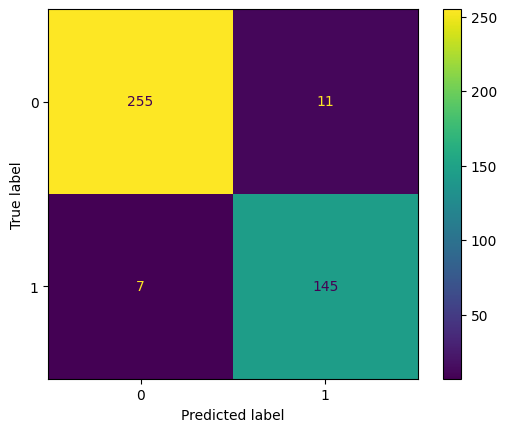

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       266
           1       0.93      0.95      0.94       152

    accuracy                           0.96       418
   macro avg       0.95      0.96      0.95       418
weighted avg       0.96      0.96      0.96       418



---

#### KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(5)
knn.fit(x_train,y_train)

/home/tothzs/Git/titanic_poc/venv/lib64/python3.13/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [18]:
knn.score(x_train, y_train)

0.8496071829405163

In [19]:
y_pred = knn.predict(x_test)

In [20]:
accuracy_score(y_test, y_pred)

0.8086124401913876

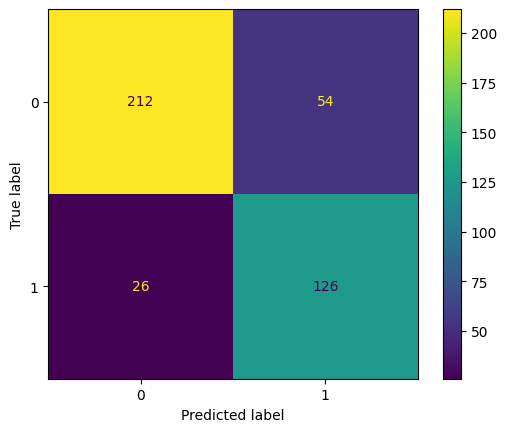

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       266
           1       0.70      0.83      0.76       152

    accuracy                           0.81       418
   macro avg       0.80      0.81      0.80       418
weighted avg       0.82      0.81      0.81       418



---

#### DecisionTree

In [23]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
dt.score(x_train, y_train)

0.9797979797979798

In [25]:
y_pred = dt.predict(x_test)

In [26]:
accuracy_score(y_test, y_pred)

0.7727272727272727

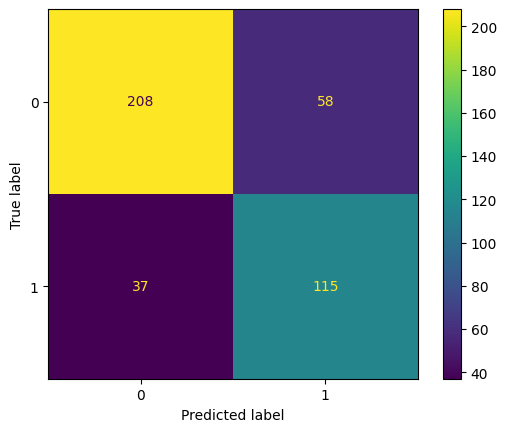

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       266
           1       0.66      0.76      0.71       152

    accuracy                           0.77       418
   macro avg       0.76      0.77      0.76       418
weighted avg       0.78      0.77      0.78       418



---

#### SVC

In [29]:
svm = SVC(kernel="rbf", C=1.0)
svm.fit(x_train, y_train)

/home/tothzs/Git/titanic_poc/venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [30]:
svm.score(x_train, y_train)

0.8125701459034792

In [31]:
y_pred = svm.predict(x_test)

In [32]:
accuracy_score(y_test, y_pred)

0.9019138755980861

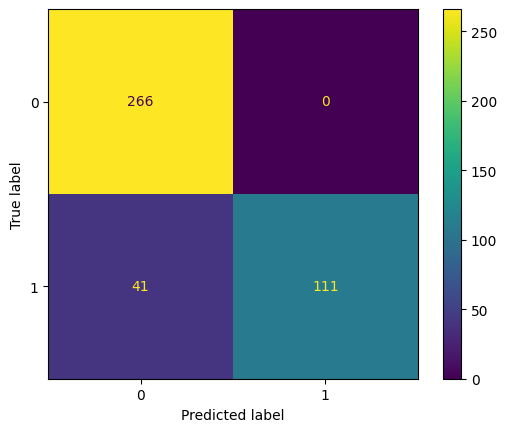

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       266
           1       1.00      0.73      0.84       152

    accuracy                           0.90       418
   macro avg       0.93      0.87      0.89       418
weighted avg       0.92      0.90      0.90       418



---

#### Lazypredict

In [36]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
PassiveAggressiveClassifier        0.98               0.98     0.98      0.98   
AdaBoostClassifier                 0.97               0.97     0.97      0.97   
LinearDiscriminantAnalysis         0.97            